#MACHINE LEARNING ASSIGNMENT MLP

In [ ]:
import numpy as np
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

**1 and 2. MLP ARCHITECTURE AND DEFINING THE ARCHITECTURE**

In [ ]:
inputNeuron = 76800
hiddenNeuron = 50
outputNeuron = 3

class MLP:
  def __init__(self):
    self.thetaIH = np.empty([inputNeuron, hiddenNeuron])
    self.biasIH = np.empty(hiddenNeuron)
    self.thetaHO = np.empty([hiddenNeuron, outputNeuron])
    self.biasHO = np.empty(outputNeuron)
    return

**3. LOADING THE DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


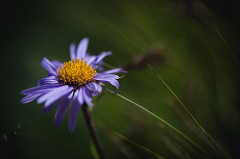

[0 0 1] 



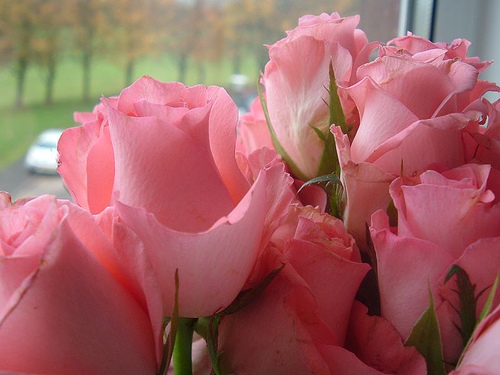

[1 0 0] 



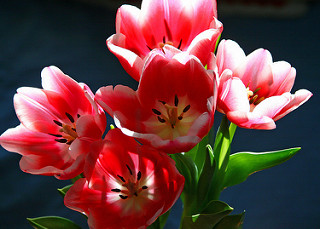

[0 1 0] 



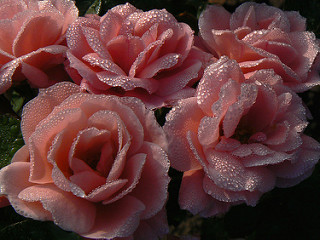

[1 0 0] 



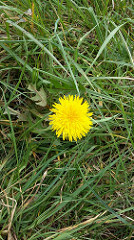

[0 0 1] 



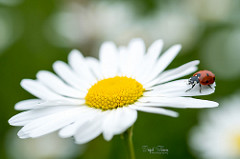

[0 0 1] 



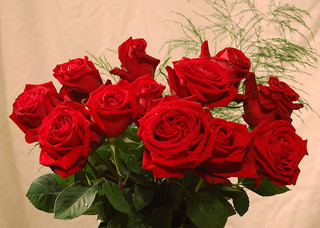

[1 0 0] 



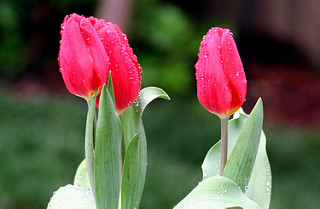

[0 1 0] 



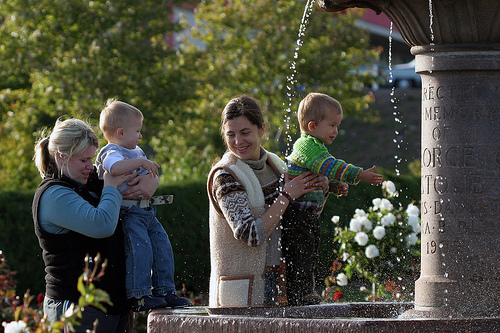

[1 0 0] 



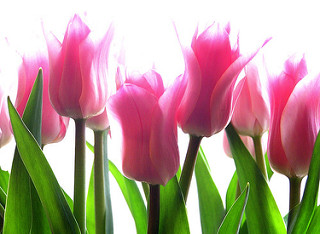

[0 1 0] 



In [ ]:
def parse(folder_path):
  dataset = []
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    for data in os.listdir(label_path):
      data_path = os.path.join(label_path, data)
      if label == 'rose':
        label_encoded = np.array([1, 0, 0])
      elif label == 'tulip':
        label_encoded = np.array([0, 1, 0])
      else:
        label_encoded = np.array([0, 0, 1])
      dataset.append((label_encoded, data_path))
  return dataset

train_paths = parse('/content/drive/MyDrive/flowers dataset/training')
test_paths = parse('/content/drive/MyDrive/flowers dataset/testing')

random.shuffle(train_paths)
random.shuffle(test_paths)

for label, data_path in train_paths[:10]:
  data = cv2.imread(data_path)
  cv2_imshow(data)
  print(label, '\n')

**4. IMAGE PROCESSING**


In [ ]:
def preprocess(img):
  '''
  print("ogimage:")
  cv2_imshow(img)
  '''
  try:
    process = cv2.resize(img, (320, 240))
    #print("1image:")
    #cv2_imshow(process)
  except: 
    return
  process = cv2.cvtColor(process, cv2.COLOR_BGR2GRAY)
  process = process.flatten()
  return process

train_dataset = [(label, preprocess(cv2.imread(data_path))) for label, data_path in train_paths]
test_dataset = [(label, preprocess(cv2.imread(data_path))) for label, data_path in test_paths]

**5. SIGMOID FUNCTION**

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

**6. BACKPROPAGATION - WEIGHT AND BIAS INITIALIZATION**

In [ ]:
def thetabiasInit(model):
  # theta between input and hidden layers
  model.thetaIH = np.random.normal(0, 2/inputNeuron, (inputNeuron, hiddenNeuron))
  model.biasIH = np.random.normal(0, 2/inputNeuron, hiddenNeuron)
  
  # theta between hidden and output layers
  model.thetaHO = np.random.normal(0, 2/hiddenNeuron, (hiddenNeuron, outputNeuron))
  model.biasHO = np.random.normal(0, 2/hiddenNeuron, outputNeuron)

**7. BACKPROPAGATION - CALCULATING ERROR**

In [ ]:
def err(actual, predicted):
  return  1/2*(predicted - actual)**2

**8. BACKPROPAGATION - FEEDFORWARD**

In [ ]:
def feedforward(input, model):
  hiddenY = sigmoid(np.dot(input, model.thetaIH) + model.biasIH)
  outputY = sigmoid(np.dot(hiddenY, model.thetaHO) + model.biasHO)

  return outputY, hiddenY

**9. BACKPROPAGATION - BACKWARD (UPDATING WEIGHT)**

In [ ]:
def backward(label, input, model, lr):
  outputY, hiddenY = feedforward(input, model)
  
  # reshape & transpose matrix
  hiddenY = hiddenY.reshape((len(hiddenY), 1))
  outputY = outputY.reshape((1, len(outputY)))
  reshapedInput = input.reshape((len(input), 1))

  # calculating error
  error = err(label, outputY)

  # delta theta of Hidden and Output layer
  derivHO = (outputY - label) * outputY * (1 - outputY)
  dthetaHO = np.dot(hiddenY, derivHO)
  
  # delta theta of Input and Hidden layer
  hiddenErr = np.dot(model.thetaHO, derivHO.T)
  derivIH = hiddenErr * hiddenY * (1 - hiddenY)
  derivIH = derivIH.reshape((1, len(derivIH)))
  dthetaIH = np.dot(reshapedInput, derivIH)

  # update theta
  model.thetaHO -= lr * dthetaHO / len(train_dataset)
  model.biasHO -= lr * derivHO[0] / len(train_dataset)
  model.thetaIH -= lr * dthetaIH / len(train_dataset)
  model.biasIH -= lr * derivIH[0] / len(train_dataset)

  # return new error
  return np.sum(err(label, feedforward(input, model)[0]))

##**10**

In [ ]:
def predict(input, model):
  predicted, _ = feedforward(input, model)
  return np.argmax(predicted)

##**11**

In [ ]:
def accuracy(model):
  test_marks = 0
  for label, data in test_dataset:
    if np.argmax(label) == predict(data, model):
      test_marks += 1
  return test_marks / len(test_dataset)

##**12**

In [ ]:
def train(model, epoch, lr):
  print("\n\nTraining model;\n epoch =", epoch, "; learning rate =", lr)
  error = []
  acc = []
  prev_log_string = ''
  for current_epoch in range(epoch):
    total_error = 0
    for data_index, (label, data) in enumerate(train_dataset):
      current_error = backward(label, data, model, lr)
      total_error += current_error
      print('\b' * len(prev_log_string), end='')
      prev_log_string = f'EPOCH {current_epoch + 1}/{epoch}, DATA {data_index}/{len(train_dataset)}'
      if len(error) > 0:
        prev_log_string += f', Model error: {error[-1]}'
      print(prev_log_string, end='')
    error.append(total_error/len(train_dataset))
    print(total_error/len(train_dataset))
    acc.append(accuracy(model))
  print("Training complete")
  return error, acc

## **13.** Visualize the error and acc for 50 epochs, and test with a learning rate of 0.1 and 0.8

In [ ]:
# visualize the error and acc
def visualize(error, acc):
  plt.title("error / Loss")
  plt.plot(error, 'r-')
  plt.show()
  plt.title("acc")
  plt.plot(acc, 'b-')
  plt.show()

# epoch 50 with learning rate of 0.1
model1 = MLP()
thetabiasInit(model1)
error1, acc1 = train(model1, 50, 0.1)
visualize(error1, acc1)
 
# epoch 50 with learning rate of 0.8
model2 = MLP()
thetabiasInit(model2)
error2, acc2 = train(model2, 50, 0.8)
visualize(error2, acc2)



Training model;
 epoch = 50 ; learning rate = 0.1
EPOCH 1/50, DATA 0/300EPOCH 1/50, DATA 1/300EPOCH 1/50, DATA 2/300EPOCH 1/50, DATA 3/300EPOCH 1/50, DATA 4/300

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


EPOCH 1/50, DATA 5/300EPOCH 1/50, DATA 6/300EPOCH 1/50, DATA 7/300EPOCH 1/50, DATA 8/300EPOCH 1/50, DATA 9/300EPOCH 1/50, DATA 10/300EPOCH 1/50, DATA 11/300EPOCH 1/50, DATA 12/300EPOCH 1/50, DATA 13/300EPOCH 1/50, DATA 14/300EPOCH 1/50, DATA 15/300EPOCH 1/50, DATA 16/300EPOCH 1/50, DATA 17/300EPOCH 1/50, DATA 18/300EPOCH 1/50, DATA 19/300EPOCH 1/50, DATA 20/300EPOCH 1/50, DATA 21/300EPOCH 1/50, DATA 22/300EPOCH 1/50, DATA 23/300EPOCH 1/50, DATA 24/300EPOCH 1/50, DATA 25/300EPOCH 1/50, DATA 26/30